### Load data for one patient

In [1]:
from src.data.data_loader import BrisT1DDataLoader
import pandas as pd
import os

# Split up data into day and night
loader = BrisT1DDataLoader(use_cached=True)

# Initialize empty lists to store patient dataframes
patients_5min = []
patients_15min = []
train_5min = None
train_15min = None
test_5min = None  # Can probably be removed
test_15min = None  # Can probably be removed

# Process each patient
for patient in loader.train_data["p_num"].unique():
    train_patient = loader.train_data[loader.train_data["p_num"] == patient]
    test_patient = loader.validation_data[loader.validation_data["p_num"] == patient]

    # use the first 2 rows to figure out the interval
    time_step = (
        train_patient["datetime"].iloc[1] - train_patient["datetime"].iloc[0]
    ).components.minutes

    # Add to appropriate list based on time step
    if time_step == 5:
        patients_5min.append(patient)
        train_5min = (
            pd.concat([train_patient])
            if len(patients_5min) == 1
            else pd.concat([train_5min, train_patient])
        )
        test_5min = (
            pd.concat([test_patient])
            if len(patients_5min) == 1
            else pd.concat([test_5min, test_patient])
        )
    elif time_step == 15:
        patients_15min.append(patient)
        train_15min = (
            pd.concat([train_patient])
            if len(patients_15min) == 1
            else pd.concat([train_15min, train_patient])
        )
        test_15min = (
            pd.concat([test_patient])
            if len(patients_15min) == 1
            else pd.concat([test_15min, test_patient])
        )
    else:
        print(f"Patient {patient} has unexpected time step of {time_step} minutes")

print(f"5-minute patients: {patients_5min}")
print(f"15-minute patients: {patients_15min}")

5-minute patients: ['p02', 'p03', 'p04', 'p10', 'p11', 'p12']
15-minute patients: ['p01', 'p05', 'p06']


### Reduce columns and impute missing values on training set

In [2]:
# import pandas as pd
from src.tuning.benchmark import impute_missing_values


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad')

    # Reduce features
    y_feature = ["bg-0:00"]
    x_features = [
        "hr-0:00",
        "steps-0:00",
        "cals-0:00",
        "cob",
        "carb_availability",
        "insulin_availability",
        "iob",
    ]
    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    y, X = p_df[y_feature], p_df[x_features]
    return y, X

c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


### Select 05 or 15 minute model to fine tune

In [3]:
use_5min = False

if use_5min:
    y_train, X_train = reduce_features(train_5min)
else:
    y_train, X_train = reduce_features(train_15min)


print(len(y_train))
print(len(X_train))

19471
19471


### Config trainning parameterse


In [4]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster
import numpy as np
import pandas as pd

# loss_callback = LossPlottingCallback()

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

training_samples = len(y_train)
batch_size = 128
steps_per_epoch = training_samples // batch_size

TIME_STEP_SIZE = 5 if use_5min else 15
SAVE_EVERY_EPOCH = 10  # How many epochs to save

interval = "05mins" if use_5min else "15mins"
dir_path = f"../../src/models/ttm/{interval}/{current_time}"

forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": (60 // TIME_STEP_SIZE) * 18,  # 18 hours of context length
        "prediction_length": (60 // TIME_STEP_SIZE) * 6,  # 6 hours of prediction length
    },
    training_args={
        "num_train_epochs": 1000,
        "output_dir": dir_path,
        "use_cpu": False,
        "per_device_train_batch_size": batch_size,
        "save_steps": steps_per_epoch * SAVE_EVERY_EPOCH,
        # "callbacks": [],  # Add the callback here, why is this not working?
    },
)

print("selected interval: ", interval)
print(f"Training samples: {training_samples}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Saving a checkpoint every {steps_per_epoch * SAVE_EVERY_EPOCH} steps")

selected interval:  15mins
Training samples: 19471
Batch size: 128
Steps per epoch: 152
Saving a checkpoint every 1520 steps


### Fit model on training set

In [5]:
HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh = np.arange(1, NUM_STEPS + 1)
forecaster.fit(y=y_train, X=X_train, fh=fh)

c:\Users\Tony\GlucoseML\nocturnal-hypo-gly-prob-forecast\.noctprob-venv\Lib\site-packages\sktime\forecasting\ttm.py:333: UserWarning: Invalid configuration detected. The provided values do not satisfy the required condition:
context_length / num_patches == patch_length == patch_stride
Provided configuration:
- context_length: 72
- num_patches: 8
- patch_length: 64
- patch_stride: 64
Configuration has been automatically updated to:
- context_length: 72
- num_patches: 8
- patch_length: 9
- patch_stride: 9
  warn(msg)
Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm/TTM and are newly initialized because the shapes did not match:
- backbone.encoder.patcher.weight: found shape torch.Size([192, 64]) in the checkpoint and torch.Size([192, 9]) in the model instantiated
- head.base_forecast_block.bias: found shape torch.Size([96]) in the checkpoint and torch.Size([24]) in the model instantiated
- head.base_forecast_block.weight: found shape torch.

Step,Training Loss
500,13.411000
1000,12.078500
1500,11.753200
2000,11.568000
2500,11.451500
3000,11.356100
3500,11.275400
4000,11.207700
4500,11.176700
5000,11.108100


TinyTimeMixerForecaster(config={'context_length': 72, 'prediction_length': 24},
                        training_args={'num_train_epochs': 1000,
                                       'output_dir': '../../src/models/ttm/15mins/2025-03-04_16-02-15',
                                       'per_device_train_batch_size': 128,
                                       'save_steps': 1520, 'use_cpu': False})

### Load the model at a given checkpoint and what patient to test
1. Change the model_path and checkpoint
2. Change the patient

In [44]:
# Change these 2 values
model_path = "../../src/models/ttm/05mins/2025-03-04_12-02-09"
checkpoint = 0
patient = "p04"


checkpoint_dirs = []

dirs = [d for d in os.listdir(model_path) if os.path.isdir(os.path.join(model_path, d))]

for dir in dirs:
    if dir.startswith("checkpoint-"):
        checkpoint_dirs.append(os.path.join(model_path, dir))

# Sort checkpoints by number
checkpoint_dirs = sorted(checkpoint_dirs, key=lambda x: int(x.split("-")[-1]))
# print(checkpoint_dirs)

# This ain't working..... The model should have been fitted already
# ttm_checkpoint = TinyTimeMixerForecaster(model_path=checkpoint_dirs[checkpoint])
ttm_checkpoint = TinyTimeMixerForecaster(
    model_path="../../src/models/ttm/05mins/2025-03-04_12-02-09/checkpoint-9250"
)
ttm_checkpoint

TinyTimeMixerForecaster(model_path='../../src/models/ttm/05mins/2025-03-04_12-02-09/checkpoint-9250')

### Plot predicted glucose levels

In [40]:
def plot_predicted(ax, forecaster, fh, X_night, test_period):
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    ax.plot(test_period.index, predicted_bg, label="Predicted glucose levels")


def plot_intervals(ax, forecaster, fh, X_night, test_period):
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=0.95)[0][0.95]
    ax.plot(
        test_period.index,
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
    )

    ax.plot(
        test_period.index,
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
    )


def plot_quantiles(ax, forecaster, fh, X_night, test_period):
    quantiles = [0.95, 0.5, 0.05]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]

    ax.plot(
        test_period.index,
        pred_int[0.05],
        linestyle="--",
        label="0.05 quantile",
    )

    ax.plot(test_period.index, pred_int[0.50], label="0.5 quantile")

    ax.plot(
        test_period.index,
        pred_int[0.95],
        linestyle="--",
        label="0.95 quantile",
    )

c:\users\tony\glucoseml\nocturnal-hypo-gly-prob-forecast\src\data\data_loader.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patient_data["datetime"] = pd.to_datetime(patient_data["datetime"])


NotFittedError: This instance of TinyTimeMixerForecaster has not been fitted yet. Please call `fit` first.

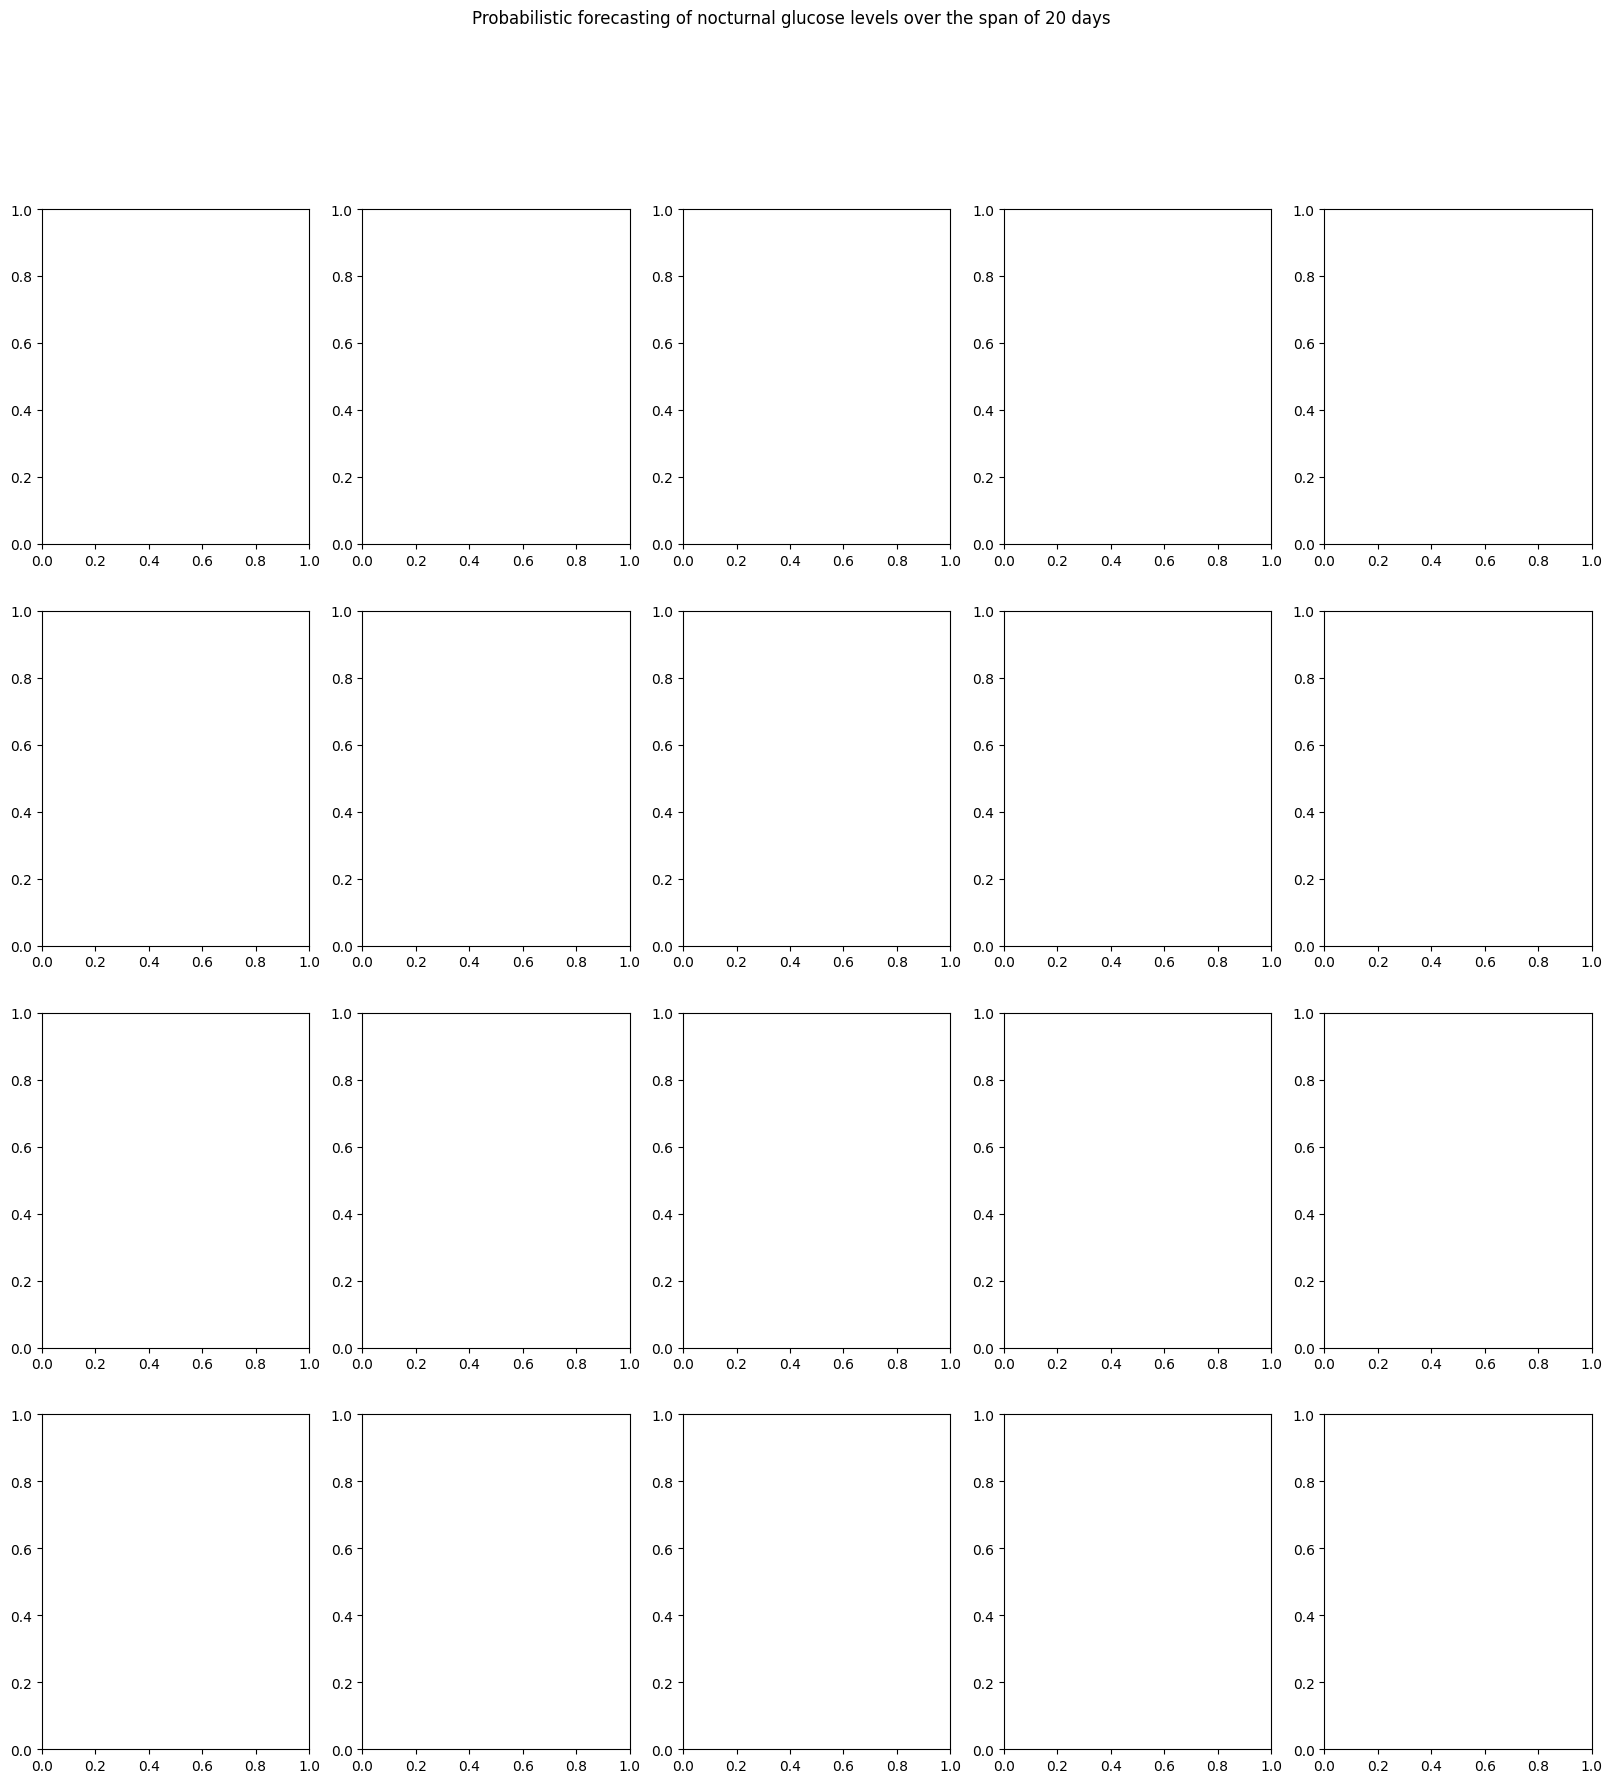

In [41]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
fig.suptitle(
    "Probabilistic forecasting of nocturnal glucose levels over the span of 20 days"
)

axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Initialize the subplot counter
subplot_idx = 0

RMS_ERRORS = np.array([])

# Loop over each day split and create one plot per day
for _, train_period, test_period in loader.get_validation_day_splits(patient):
    y_day, X_day = reduce_features(train_period)
    y_night, X_night = reduce_features(test_period)

    if X_day.isna().sum().any() > 0:
        print(X_day)
    if X_night.isna().sum().any() > 0:
        print(X_night)

    # Update the model with the true glucose levels for the day
    forecaster.update(y=y_day, X=X_day, update_params=False)

    ######## Plot true glucose levels ########
    ax = axes[subplot_idx]
    ax.plot(
        train_period.index,
        y_day["bg-0:00"],
        color="skyblue",
        label="True glucose levels",
    )
    ax.plot(
        test_period.index,
        y_night["bg-0:00"],
        color="skyblue",
        linestyle="--",
        label="True nocturnal glucose levels",
    )

    ######## Determine MSE between predicted and true glucose levels ########
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    mse = np.sqrt(np.mean((predicted_bg.values - y_night["bg-0:00"].values) ** 2))
    RMS_ERRORS = np.append(RMS_ERRORS, mse)
    ax.set_title(f"RMSE: {mse:.2f}")

    ######## Plot predicted glucose levels ########
    plot_predicted(ax, forecaster, fh, X_night, test_period)
    # plot_intervals(ax, forecaster, fh, X_night, test_period)
    # plot_quantiles(ax, forecaster, fh, X_night, test_period)

    # Add labels, legend, and formatting for each subplot
    ax.set_xlabel("Time", fontsize=10)
    ax.set_ylabel("BGL", fontsize=10)
    ax.set_ylim(0, 20)  # Set the y-axis limits as needed
    ax.legend()
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    # Update the model with the true glucose levels for the night
    forecaster.update(y=y_night, X=X_night, update_params=False)

    # Increment the subplot index for the next day
    subplot_idx += 1

# Adjust layout to avoid overlap
plt.tight_layout(pad=2.0)

# Show the figure with multiple subplots
plt.show()

print(RMS_ERRORS.mean())